In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import pysam
import tensorflow as tf
from basenji import seqnn, stream
import matplotlib.pyplot as plt
import seaborn as sns

from akita_utils.seq_gens import unshuffled_insertion_gen
from akita_utils.numpy_utils import ut_dense

In [2]:
# parameters
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa"
rc = False
stats = "SCD"
shifts = "0"
batch_size = 4
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

params_file = "/project/fudenber_735/tensorflow_models/akita/v2/models/f0c0/train/params.json"
model_file = "/project/fudenber_735/tensorflow_models/akita/v2/models/f0c0/train/model0_best.h5"

head_index = int(model_file.split("model")[-1][0])
model_index = int(model_file.split("c0")[0][-1])

shuffled_seqs_tsv = "./example_maps.tsv"

### Loading the model

In [3]:
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Reading the table with genomic coordinates

In [4]:
seq_coords_df = pd.read_csv(shuffled_seqs_tsv, sep="\t")
num_experiments = len(seq_coords_df)*2

In [5]:
# open genome FASTA
genome_open = pysam.Fastafile(
    genome_fasta
)

In [6]:
ctcf_site_coordinates = ("chr4", 87368268, 87368249, "+")
# CTCF site to be insered

In [7]:
preds_stream = stream.PredStreamGen(
    seqnn_model,
    unshuffled_insertion_gen(seq_coords_df, genome_open, ctcf_site_coordinates),
    batch_size,
)

target 0


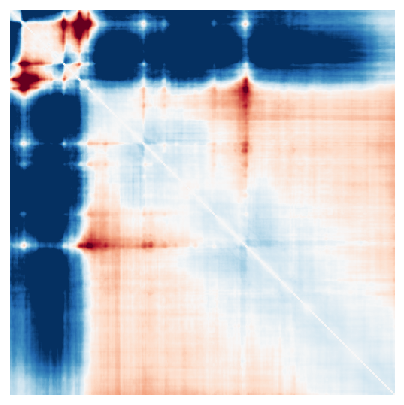

target 1


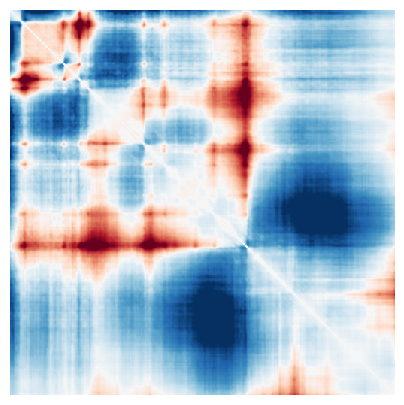

target 2


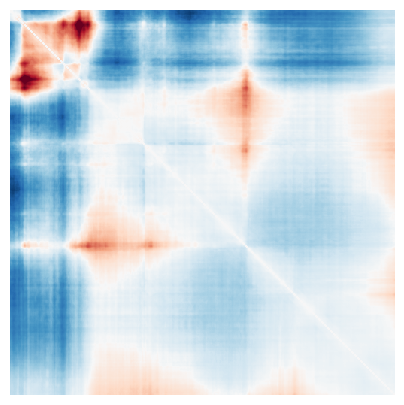

target 3


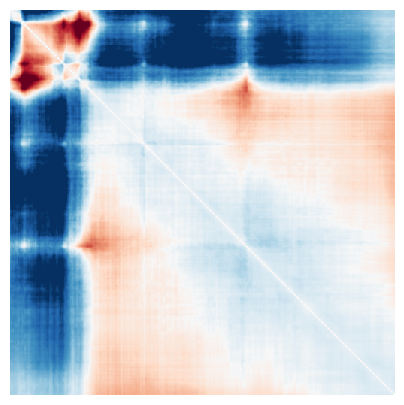

target 4


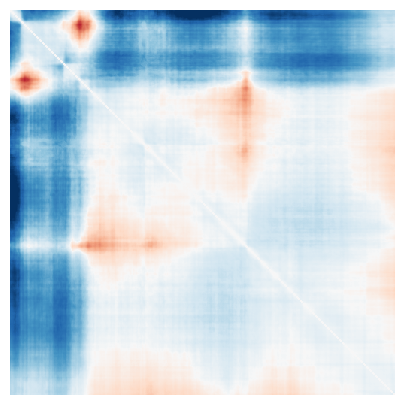

target 0


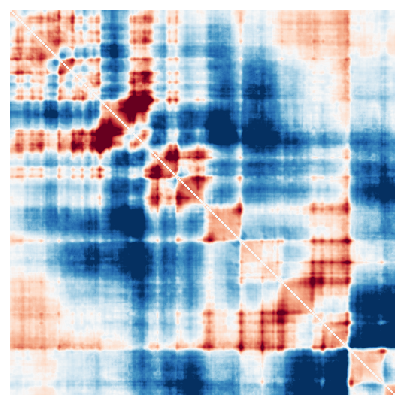

target 1


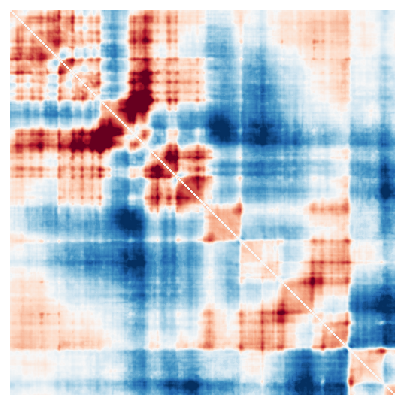

target 2


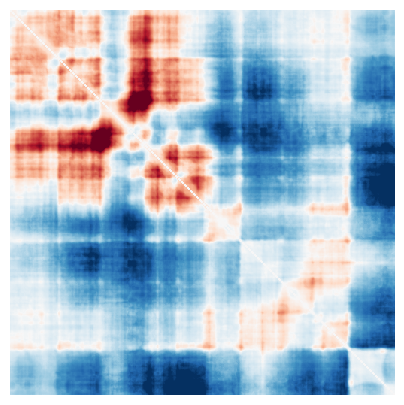

target 3


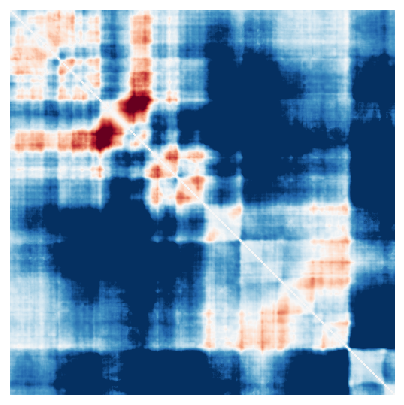

target 4


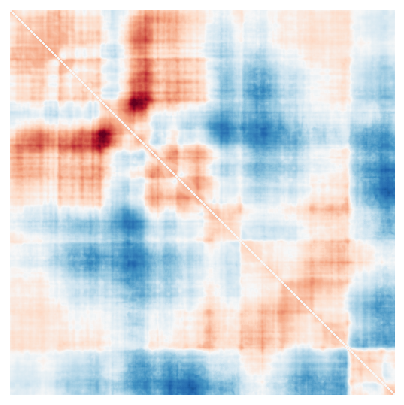

In [9]:
for exp_index in range(0, 10, 2):

    if exp_index == 0 or exp_index == 8:
        reference_prediction_matrix = preds_stream[exp_index]
        # prediction_matrix = preds_stream[exp_index+1]
    
        ref_maps = ut_dense(reference_prediction_matrix)
        # alt_maps = ut_dense(prediction_matrix)

        vmin=-0.6
        vmax=0.6
        width=5
        height=5
        palette="RdBu_r"
        
        for i in range(5):        
            print("target", i)
        
            fig = plt.figure(figsize=(width, height))
    
            sns.heatmap(
                ref_maps[:,:,i],
                vmin=vmin,
                vmax=vmax,
                cbar=False,
                cmap=palette,
                square=True,
                xticklabels=False,
                yticklabels=False,
            )
            # plt.savefig(f"./example_maps/map{exp_index}_human_tg{i}_model0.pdf", format="pdf", bbox_inches="tight")
            # plt.savefig(f"./example_maps/map{exp_index}_human_tg{i}_model0.png", format="png", bbox_inches="tight")
            plt.show() 

In [10]:
genome_open.close()